# Table of contents
1. [EDA](#eda)
2. [Q1: Longest hitting streak](#q1)
3. [Q2: Longest streak throughout season](#q2)
3. [Q3: Longest streak and batting average](#q3)
3. [Q4: Function for streak probability](#q4)
3. [Q5: Grouping players](#q5)
3. [Q6: Linear model for streakiness](#q6)



In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics
import seaborn as sns
import more_itertools as mit
import math
from sklearn.linear_model import SGDClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## EDA: Understanding the data <a name="eda"></a>

In [2]:
df = pd.read_csv('data.csv')

df.head()

,mlb_player_id,batter,game_date,singles,doubles,triples,home_runs,strikeouts,walks,hit_by_pitches,field_outs,sacrifices,reached_on_errors
0,665923,"Ruiz, Esteury",4/29/2023,1,0,0,0,2,0,0,2,0,0
1,571448,"Arenado, Nolan",5/24/2023,0,0,0,0,2,1,0,1,0,0
2,650333,"Arraez, Luis",5/13/2023,0,1,0,0,0,0,0,4,0,0
3,683011,"Volpe, Anthony",9/20/2023,0,0,0,0,2,0,0,2,0,0
4,671739,"Harris, Michael",6/3/2023,1,0,0,0,0,0,0,3,0,0


In [3]:
df.shape

(48197, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48197 entries, 0 to 48196
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mlb_player_id      48197 non-null  int64 
 1   batter             48197 non-null  object
 2   game_date          48197 non-null  object
 3   singles            48197 non-null  int64 
 4   doubles            48197 non-null  int64 
 5   triples            48197 non-null  int64 
 6   home_runs          48197 non-null  int64 
 7   strikeouts         48197 non-null  int64 
 8   walks              48197 non-null  int64 
 9   hit_by_pitches     48197 non-null  int64 
 10  field_outs         48197 non-null  int64 
 11  sacrifices         48197 non-null  int64 
 12  reached_on_errors  48197 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 4.8+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mlb_player_id,48197.0,630769.493018,56358.333863,408234.0,605137.0,656669.0,669134.0,807799.0
singles,48197.0,0.540096,0.721741,0.0,0.0,0.0,1.0,6.0
doubles,48197.0,0.170716,0.410849,0.0,0.0,0.0,0.0,4.0
triples,48197.0,0.014773,0.122011,0.0,0.0,0.0,0.0,2.0
home_runs,48197.0,0.121750,0.350105,0.0,0.0,0.0,0.0,3.0
strikeouts,48197.0,0.868166,0.876377,0.0,0.0,1.0,1.0,6.0
walks,48197.0,0.328215,0.579746,0.0,0.0,0.0,1.0,5.0
hit_by_pitches,48197.0,0.043820,0.210198,0.0,0.0,0.0,0.0,3.0
field_outs,48197.0,1.673756,1.105447,0.0,1.0,2.0,2.0,9.0
sacrifices,48197.0,0.034421,0.184573,0.0,0.0,0.0,0.0,2.0


In [6]:
df.isna().sum()

mlb_player_id        0
batter               0
game_date            0
singles              0
doubles              0
triples              0
home_runs            0
strikeouts           0
walks                0
hit_by_pitches       0
field_outs           0
sacrifices           0
reached_on_errors    0
dtype: int64

In [7]:
display(df.dtypes)

mlb_player_id         int64
batter               object
game_date            object
singles               int64
doubles               int64
triples               int64
home_runs             int64
strikeouts            int64
walks                 int64
hit_by_pitches        int64
field_outs            int64
sacrifices            int64
reached_on_errors     int64
dtype: object

We have no missing values to deal with! And most of our explanatory variables are integers.

In [8]:
df['game_date'].nunique()

183

In [9]:
df['game_date'].value_counts()

9/12/2023    328
9/5/2023     321
8/19/2023    320
9/3/2023     320
9/30/2023    319
            ... 
3/31/2023     96
7/27/2023     89
8/31/2023     81
9/25/2023     80
10/2/2023     19
Name: game_date, Length: 183, dtype: int64

In [10]:

df['game_date'] = pd.to_datetime(df['game_date'])
df['any_hits'] = np.where((df['singles']!=0) | (df['doubles']!=0) | (df['triples']!=0) | (df['home_runs']!=0),True,False)
df.sort_values(by=['batter','game_date'])

,mlb_player_id,batter,game_date,singles,doubles,triples,home_runs,strikeouts,walks,hit_by_pitches,field_outs,sacrifices,reached_on_errors,any_hits
2260,682928,"Abrams, CJ",2023-03-30,0,0,0,0,1,0,0,3,0,0,False
26146,682928,"Abrams, CJ",2023-04-01,0,0,0,0,0,0,0,3,0,0,False
47751,682928,"Abrams, CJ",2023-04-03,0,0,0,0,0,1,0,3,0,0,False
23522,682928,"Abrams, CJ",2023-04-04,1,1,0,0,0,0,1,1,0,0,True
37330,682928,"Abrams, CJ",2023-04-05,0,0,0,0,2,0,0,2,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4118,518595,"d'Arnaud, Travis",2023-09-21,1,0,0,0,1,2,0,1,0,0,True
3159,518595,"d'Arnaud, Travis",2023-09-24,0,0,0,0,2,0,1,2,0,0,False
34277,518595,"d'Arnaud, Travis",2023-09-28,0,0,0,0,3,0,0,1,0,0,False
29236,518595,"d'Arnaud, Travis",2023-09-29,2,0,0,0,1,1,1,0,0,0,True


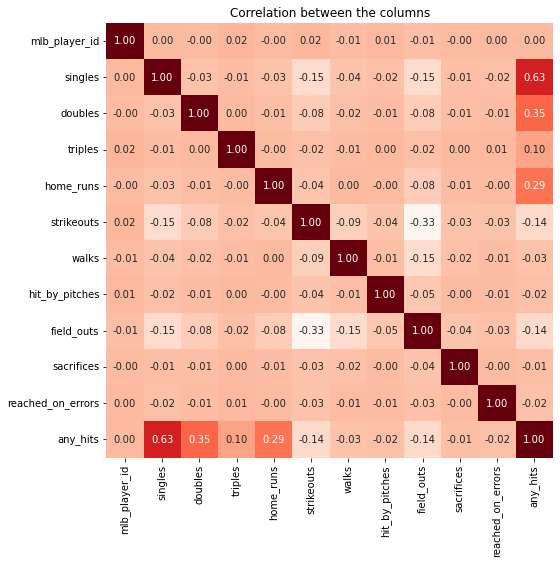

In [11]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Reds', fmt='.2f')
plt.title("Correlation between the columns")
plt.show()


#corr = df.corr()[['any_hits']].sort_values(by='any_hits', ascending=False)
#sns.heatmap(corr, annot=True)

Many correlations are quite low, and the larger ones make intuitive sense.

In [12]:
df = df.sort_values(by=['batter','game_date'])
df.head()

,mlb_player_id,batter,game_date,singles,doubles,triples,home_runs,strikeouts,walks,hit_by_pitches,field_outs,sacrifices,reached_on_errors,any_hits
2260,682928,"Abrams, CJ",2023-03-30,0,0,0,0,1,0,0,3,0,0,False
26146,682928,"Abrams, CJ",2023-04-01,0,0,0,0,0,0,0,3,0,0,False
47751,682928,"Abrams, CJ",2023-04-03,0,0,0,0,0,1,0,3,0,0,False
23522,682928,"Abrams, CJ",2023-04-04,1,1,0,0,0,0,1,1,0,0,True
37330,682928,"Abrams, CJ",2023-04-05,0,0,0,0,2,0,0,2,0,0,False


## Q 1) Which player had the longest hitting streak (consecutive games with at least one hit)? <a name="q1"></a>

In [13]:


batters = df.batter.unique()
longest_hit_streak = 0
arr_of_all_players_best_streak = np.zeros(len(batters))
arr_of_all_players = []
ii = 0
for batter in batters:
    df_batter = df[df['batter']==batter]
    
    # Want longest streak of True's
    bool_arr = list(mit.run_length.encode(df_batter['any_hits']))
    
    # From stackoverflow user Devesh Kumar Singh, https://stackoverflow.com/questions/56301970/how-can-i-return-the-longest-continuous-occurrence-of-true-in-boolean-and-rep
    #-----------------------
    max_true_count = -1 ;max_true_idx  = -1
    for idx, (val, count) in enumerate(bool_arr):
        if val and max_true_count < count:
            max_true_count = count
            max_true_idx = idx
    elems_before_idx = sum((idx[1] for idx in bool_arr[:max_true_idx]))
    #-----------------------
    
    
    # max_true_count is max number of True's
    # this string of True's starts at index elems_before_idx
    
    if max_true_count > longest_hit_streak:
        longest_hit_streak = max_true_count
        batter_with_longest_streak = batter
    arr_of_all_players_best_streak[ii] = max_true_count
    arr_of_all_players.append(batter)
    ii+=1
    
print('Batter with the longest streak: '+str(batter_with_longest_streak))    

Batter with the longest streak: Semien, Marcus


Text(0, 0.5, 'Best streak')

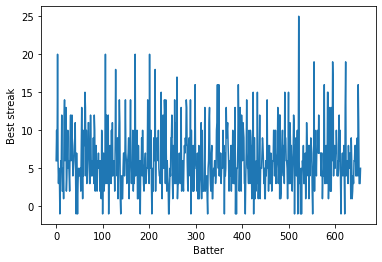

In [14]:
plt.plot(arr_of_all_players_best_streak)
plt.xlabel('Batter')
plt.ylabel('Best streak')
#print(arr_of_all_players[510:530])


## Q 2) Create a data visualization that shows the longest active hitting streak at any point in time during the season. <a name="q2"></a>

In [15]:
def find_all_batters_best_streak_at_this_date(date):    
    longest_hit_streak = 0
    arr_of_all_players_best_streak = np.zeros(len(batters))
    ii = 0
    for batter in batters:
        df_batter = df[(df['batter']==batter) & (df['game_date'] <= date)]
    
    
        bool_arr = list(mit.run_length.encode(df_batter['any_hits']))
        max_true_count = -1 ;max_true_idx  = -1
        for idx, (val, count) in enumerate(bool_arr):
            if val and max_true_count < count:
                max_true_count = count
                max_true_idx = idx
        elems_before_idx = sum((idx[1] for idx in bool_arr[:max_true_idx]))
    
    
        if max_true_count > longest_hit_streak:
            longest_hit_streak = max_true_count
            batter_with_longest_streak = batter
        arr_of_all_players_best_streak[ii] = max_true_count
        ii+=1
    return arr_of_all_players_best_streak

Text(0, 0.5, 'Best streak')

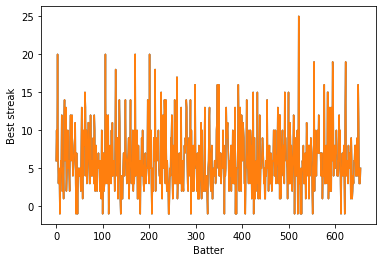

In [16]:
# Testing the function; the two plots should overlap
test_res = find_all_batters_best_streak_at_this_date('2023-10-01')
plt.plot(test_res)
plt.plot(arr_of_all_players_best_streak)
plt.xlabel('Batter')
plt.ylabel('Best streak')


Negatives are present because I set max_true_count = -1 ;max_true_idx  = -1

Text(0, 0.5, 'Best streak as of 2023-03-31')

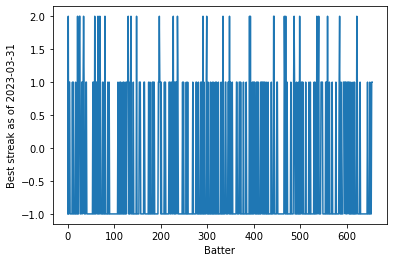

In [17]:
test_res = find_all_batters_best_streak_at_this_date('2023-03-31')
plt.plot(test_res)
plt.xlabel('Batter')
plt.ylabel('Best streak as of 2023-03-31')

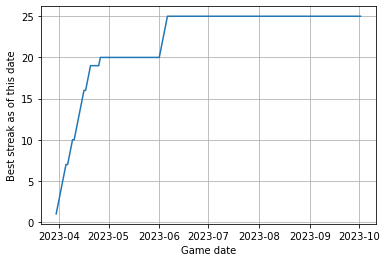

In [18]:

all_dates = np.array(np.sort(df['game_date'].unique()))
current_best_streak = np.zeros(len(all_dates))
current_best_num = 0
    
ii = 0
for date in all_dates:
    current_best_streak[ii] = np.max(find_all_batters_best_streak_at_this_date(date))
    ii += 1        
    
    if np.max(current_best_streak) > current_best_num:
        current_best_num = np.max(current_best_streak)
plt.plot(all_dates,current_best_streak)   
plt.xlabel('Game date')
plt.ylabel('Best streak as of this date')
plt.grid(True)

Text(0.5, 1.0, 'Semien`s record: 1 if any hits, 0 if not')

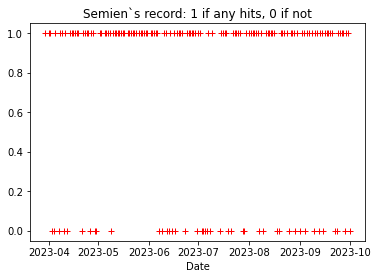

In [19]:
# Can check this: Was Marcus Semien's streak done in early June? 
plt.plot(df[df['batter']=='Semien, Marcus']['game_date'],df[df['batter']=='Semien, Marcus']['any_hits']
,'r+')
plt.xlabel('Date')
plt.title('Semien`s record: 1 if any hits, 0 if not')

It appears so!



## Q 3) Calculate every player’s longest hitting streak and batting average for the season. What is the relationship between these 2 variables? What conclusions can be drawn from this relationship? <a name="q3"></a>

Actually, I did this first part in Q1. 

Now for the batting average of each player.
Per MLB's site, "batting average is determined by dividing a player's hits 
by his total at-bats for a number between zero (shown as .000) and one (1.000). 
In recent years, the league-wide batting average has typically hovered around .250."

Player has no at-bats: Cano, Yennier


Text(0, 0.5, 'Batting average')

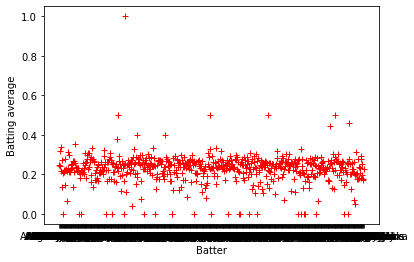

In [20]:
# bat_avg = hits / tot_atbats
each_players_bat_avg = np.zeros(len(batters))
ii = 0
for batter in batters:
    df_batter = df[df['batter']==batter]
    hits = sum(df_batter['singles']) + sum(df_batter['doubles']) + sum(df_batter['triples']) + sum(df_batter['home_runs'])
    at_bats = hits + sum(df_batter['strikeouts']) + sum(df_batter['field_outs'])
    
    if at_bats == 0:
        print('Player has no at-bats: '+str(batter))
        each_players_bat_avg[ii] = 0.
    else:
        each_players_bat_avg[ii] = hits / at_bats
    ii += 1
    
plt.plot(batters,each_players_bat_avg,'r+')
plt.xlabel('Batter')
plt.ylabel('Batting average')


Text(0, 0.5, 'Batting Average')

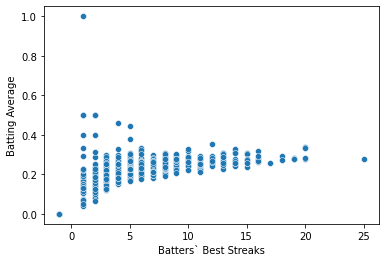

In [21]:

sns.scatterplot(arr_of_all_players_best_streak,each_players_bat_avg)
plt.xlabel('Batters` Best Streaks')
plt.ylabel('Batting Average')
# The -1 on x-axis isn't important; I set values to -1 by default

Text(0, 0.5, 'Batting Average')

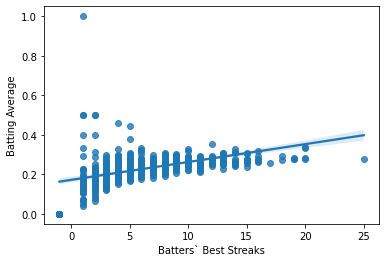

In [22]:
sns.regplot(arr_of_all_players_best_streak,each_players_bat_avg)
plt.xlabel('Batters` Best Streaks')
plt.ylabel('Batting Average')

Text(0, 0.5, 'Batting Average')

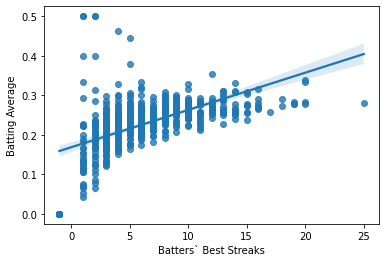

In [23]:
#There is  certainly a trend. Let's remove outliers
remove = np.where(each_players_bat_avg==1.)
each_players_bat_avg_remove = np.delete(each_players_bat_avg,remove)
arr_of_all_players_best_streak_remove = np.delete(arr_of_all_players_best_streak,remove)
sns.regplot(arr_of_all_players_best_streak_remove,each_players_bat_avg_remove)
plt.xlabel('Batters` Best Streaks')
plt.ylabel('Batting Average')

There is certainly a trend: a player's batting average is positively correlated with their best streaks (roughly, an increase in 0.100 batting average means a best streak increase of 10). There are however outliers, i.e. some players with much higher batting averages do not have very long streaks.




## Q 4) Assume that a player receives exactly n at-bats per game in a 162-game season, and that in each at-bat, he has a probability of p of getting a base hit. Then, build a function foo(n, p, x) that computes the probability of observing a hitting streak of at least x games for this player. Using this function with n = 4, determine the lowest value of p for which a 25-game hitting streak has at least a 20% probability of occurring. <a name="q4"></a>

I found a formula for the probability for the length of the longest run in 𝑛
 Bernoulli trials from https://math.stackexchange.com/questions/59738/probability-for-the-length-of-the-longest-run-in-n-bernoulli-trials/59749#59749 , where a user cites mathematician de Moivre in 1738.

In [24]:
def foo(num_games,n,p,x):
    # n at-bats per game
    # p is probability of getting base hit in each at-bat
    # want prob of seeing a hitting streak of at least x games
    
    p_one = 1 - (1-p)**n #prob of at least one hit
    res = 0
    for j in range(1,round(num_games/x)):
        res += (-1)**(j+1) * (p_one + (num_games-j*x+1)/j*(1-p_one)
                             )*(math.factorial(num_games-j*x)/(math.factorial(j-1)*math.factorial(num_games-j*x-j+1)))*p_one**(j*x)*(1-p_one)**(j-1)
    
    return res

As a test, I compare with "Fat Chance" by Grinstead and Snell (https://math.dartmouth.edu/~prob/prob/NEW/bestofchance.pdf, page 42). For a 154-game season, 4 at-bats, probability 0.35 of getting a hit at each at-bat, they find the probability of a 56 game streak is about 0.0003.

In [25]:
foo(154,4,.35,56)

0.00030538448569792634

Now for the assigned question:

Text(0, 0.5, 'Probability of 25-game streak')

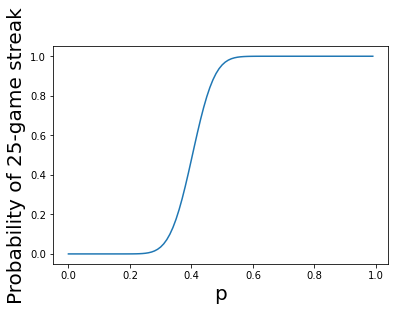

In [26]:
res_arr = np.zeros(100)
p_arr = np.zeros(100)
for i in range(100):
    p_i = i /100
    p_arr[i] = p_i
    res_arr[i] = foo(162,4,p_i,25)
    
plt.plot(p_arr,res_arr)
plt.xlabel('p',fontsize=20)
plt.ylabel('Probability of 25-game streak',fontsize=20)

In [27]:
p_arr[res_arr>.25][0]

0.37

So, p must be at least about 0.37 to have a 20 percent chance of the 25-game streak.



## Q 5) Construct a system that groups similar players based on any metrics that you’d like to create (e.g. games played, batting average, on-base percentage, etc.). Are any of these groups more or less prone to longer hitting streaks? <a name="q5"></a>

I consider grouping the players based on number of games played and players' batting averages.

Text(0, 0.5, 'Best streak')

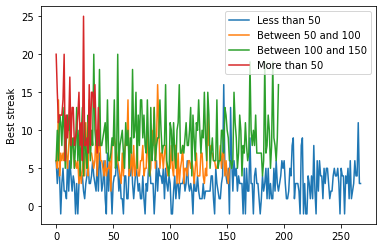

In [28]:
# Frist, group based on number of games played
ii = 0
num_games_played = np.zeros(len(batters))
for batter in batters:
    df_batter = df[df['batter']==batter]
    num_games_played[ii] = len(df_batter['game_date'])
    ii += 1
#plt.plot(num_games_played)


#Find indices that give players who played within each range of games
indices_0_50 = [];indices_50_100 = [];indices_100_150 = [];indices_150_up = []
for i in range(len(num_games_played)):
    if num_games_played[i] < 50:
        indices_0_50.append(i)
    elif num_games_played[i] < 100:
        indices_50_100.append(i)
    elif num_games_played[i] < 150:
        indices_100_150.append(i)
    else:
        indices_150_up.append(i)
        
plt.plot(arr_of_all_players_best_streak[indices_0_50],label='Less than 50')
plt.plot(arr_of_all_players_best_streak[indices_50_100],label='Between 50 and 100')
plt.plot(arr_of_all_players_best_streak[indices_100_150],label='Between 100 and 150')
plt.plot(arr_of_all_players_best_streak[indices_150_up],label='More than 50')
plt.legend()
plt.rcParams['figure.figsize'] = [25, 10]
plt.ylabel('Best streak')
# x axis not particularly meaningful; just an index for each player in each of the four categories

There does seem to be a correlation between number of games played and streak length, which makes sense.

array([0.20578163, 0.23783812, 0.26331719])

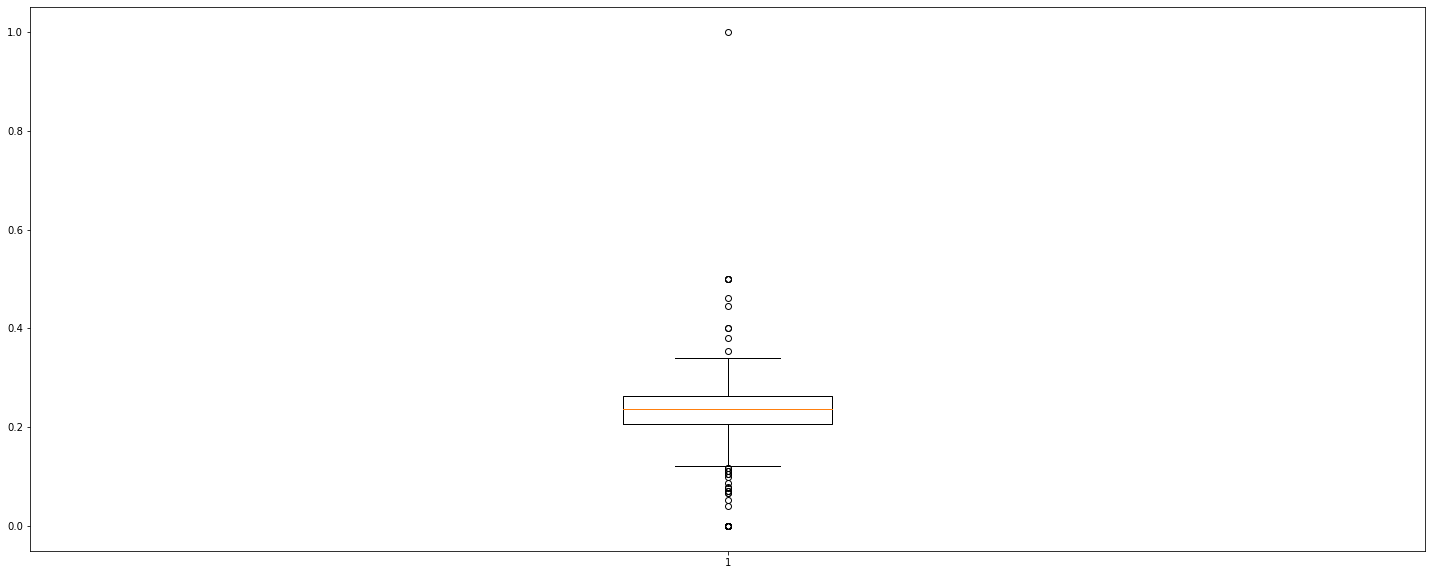

In [29]:
# Second, batting average

#plt.plot(each_players_bat_avg)
plt.boxplot(each_players_bat_avg)

np.percentile(each_players_bat_avg, [25, 50, 75])

<AxesSubplot:ylabel='Count'>

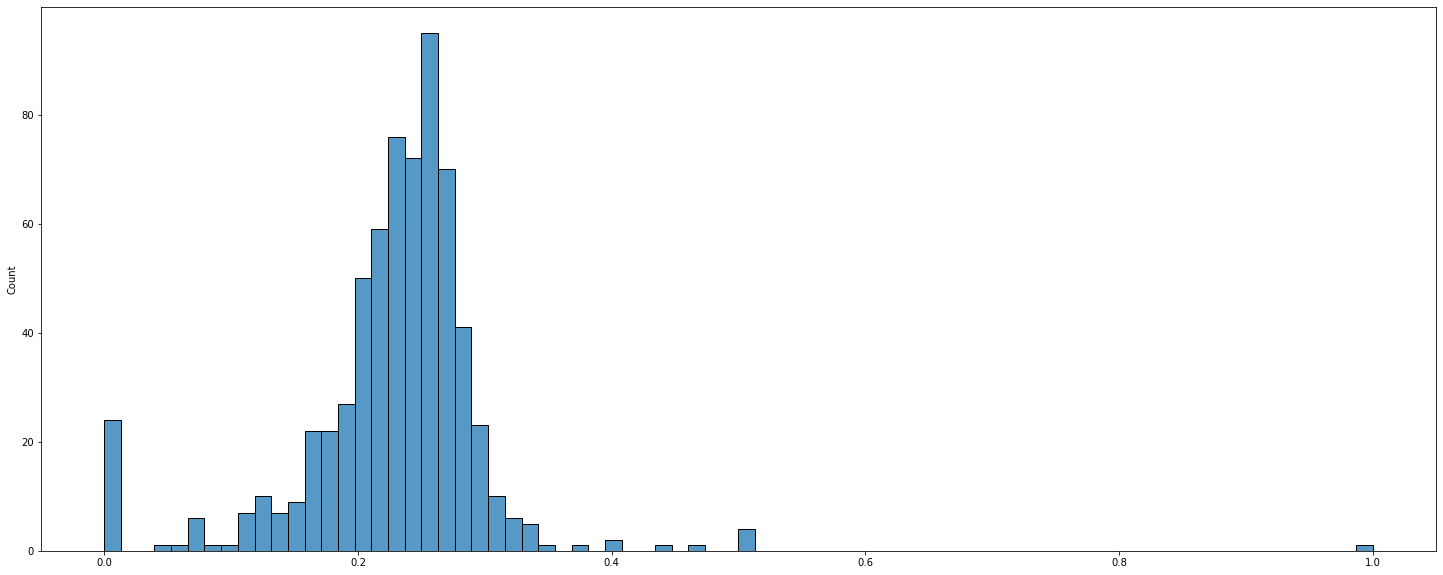

In [30]:
sns.histplot(each_players_bat_avg)

Batting averages are pretty tighly concentrated around 0.2-0.3.

Text(0, 0.5, 'Best streak')

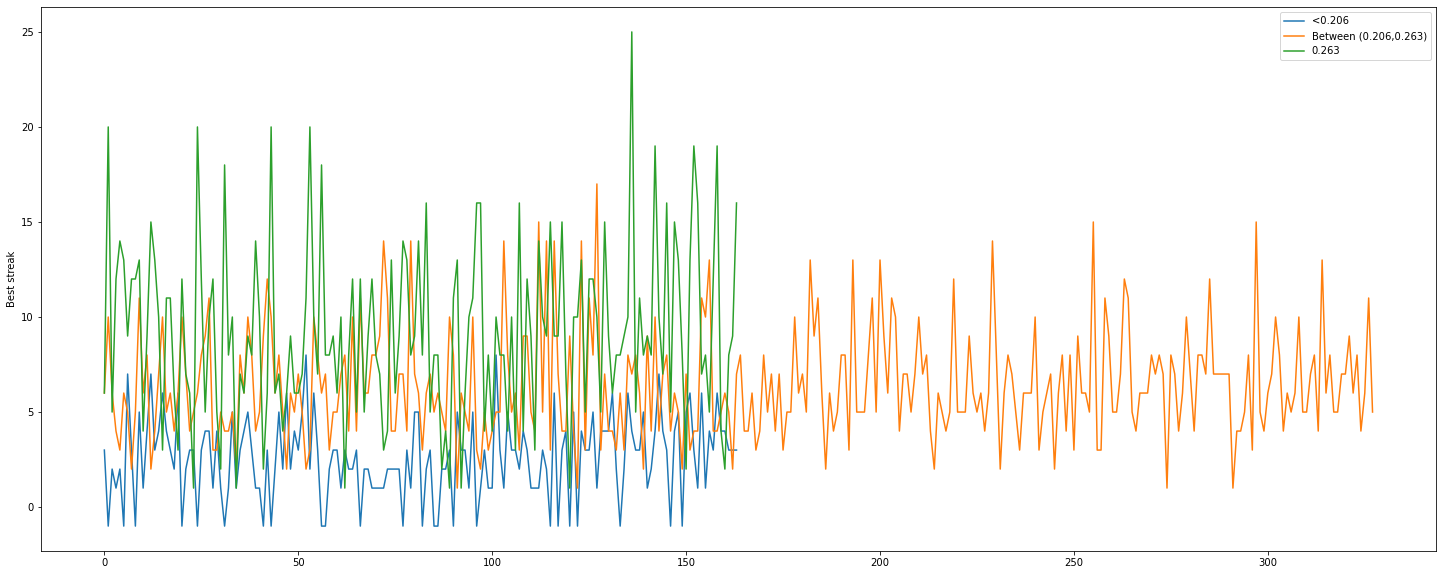

In [31]:
# I'll make three categories, for players below the first quartile,
# between the first and third quartile, and those above.
low_avg_indices = [];mid_avg_indices = [];high_avg_indices = []
for i in range(len(batters)):
    if each_players_bat_avg[i] < 0.20578163:
        low_avg_indices.append(i)
    elif each_players_bat_avg[i] < 0.26331719:
        mid_avg_indices.append(i)
    else:
        high_avg_indices.append(i)
    
        
plt.plot(arr_of_all_players_best_streak[low_avg_indices],label='<0.206')
plt.plot(arr_of_all_players_best_streak[mid_avg_indices],label='Between (0.206,0.263)')
plt.plot(arr_of_all_players_best_streak[high_avg_indices],label='0.263')
plt.legend()
plt.rcParams['figure.figsize'] = [25, 10]
plt.ylabel('Best streak')

Again, there is a positive correlation between batting average and best streak, as one would expect.



## Q 6) Can you test whether streakiness (i.e., “hot hand”) is a real performance phenomenon, or whether we’re just seeing randomness? To do this, design and implement a generalized linear model (GLM) that learns the predictive impact of having a 3+ game hitting streak on getting a hit during the next game. <a name="q6"></a>


As this is a binary classification problem, I'll use simple Logistic Regression, a simple case of GLM with binomial distribution and the logit link function.

In [32]:
# Helper function to use with various models
def model_eval(data,mod=LogisticRegression(random_state=0),size_test=0.3,show_cm=False):
    
    X = data.drop(columns=['any_hits','batter','game_date','mlb_player_id']) 
    y = data['any_hits']
    
    # train test split
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=size_test, 
                                                            random_state=0,
                                                           stratify=y)

    # Instantiate model
    model = mod
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    
    # Find accuracy and f1 score
    score = model.score(x_test, y_test)
    f1_res = f1_score(y_test,predictions)
    
    if show_cm==True: 
        cm = metrics.confusion_matrix(y_test, predictions)
        print(cm)

    
    return score, f1_res

I look at both accuracy and f1 score, as we want to avoid false negatives and positives.

I'll first see how well we can predict whether or not a player gets any hits, regardless of whether or not they are on a streak.

In [33]:


score_arr_LR = []
f1_arr_LR = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter] 
    
    # only if df_batter contains both classes, True and False
    if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
       
        score,f1= model_eval(df_batter)
        score_arr_LR.append(score)
        f1_arr_LR.append(f1)
print('Avg accuracy: '+str(np.mean(score_arr_LR)))
print('Avg f1: '+str(np.mean(f1_arr_LR)))

#cm = metrics.confusion_matrix(y_test, predictions)
#print(cm)



Avg accuracy: 0.9088121402310363
Avg f1: 0.8609987514298557


These are the average scores for all players, ignoring cases where the any_hits column had only True or False values.

In [34]:
# how does model perform for the highest streak?
df_batter = df[df['batter'] == 'Semien, Marcus']
print(model_eval(df_batter))

(1.0, 1.0)


In [35]:
# skipped this many players, as they had either no Trues or Falses
print('Number of players skipped: '+str(len(batters)-len(score_arr_LR) ))

Number of players skipped: 43


Text(0, 0.5, 'f1')

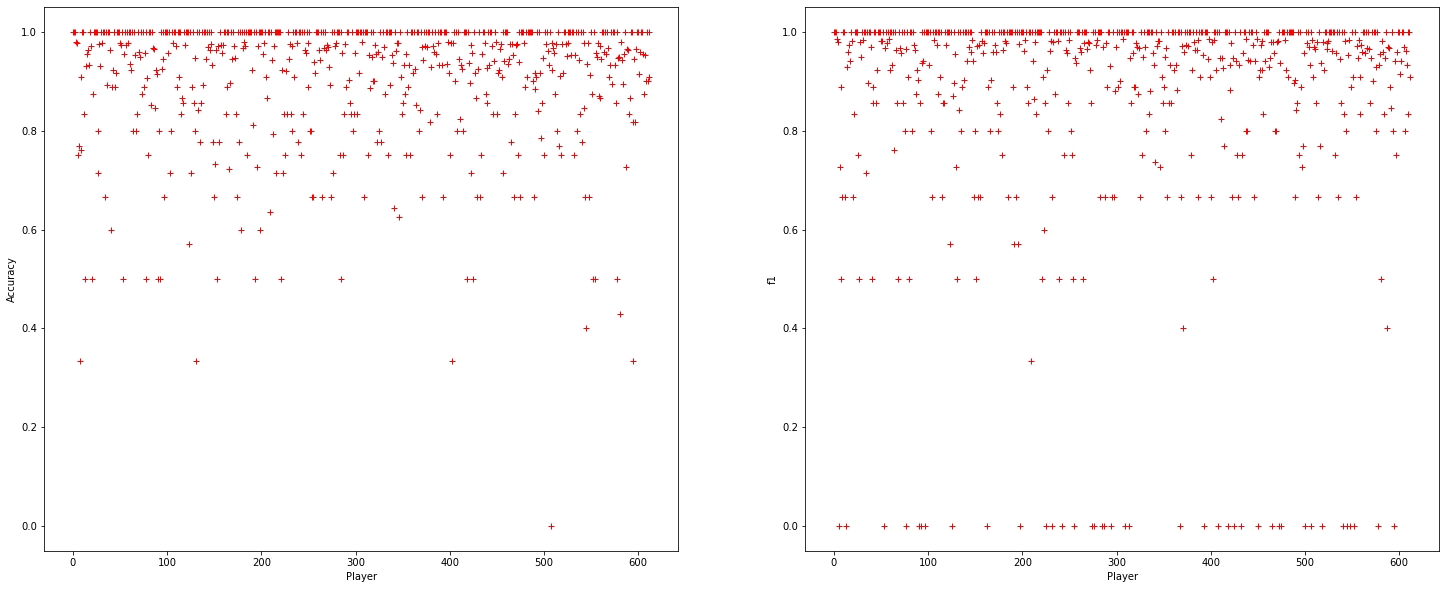

In [36]:
plt.subplot(1, 2, 1)
plt.plot(score_arr_LR,'r+')
plt.xlabel('Player')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(f1_arr_LR,'r+')
plt.xlabel('Player')
plt.ylabel('f1')

In [37]:
# Why f1=0?
    
df_batter = df[df['batter'] == 'Adams, Jordyn']
    
    
if len(df_batter[df_batter['any_hits']==True])!=len(df_batter) and len(df_batter[df_batter['any_hits']==False])!=len(df_batter) and len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
      
    score,f1 = model_eval(df_batter)
    print('score: '+str(score))
    print('score: '+str(f1))
#cm = metrics.confusion_matrix(y_test, predictions)
#print(cm)
#print(y_test)

# No true positives!

score: 0.75
score: 0.0


I'll also try the SGDClassifier, regularized linear model with stochastic gradient descent .

Mean accuracy: 0.9307649254197015
Mean f1: 0.9047604650980251


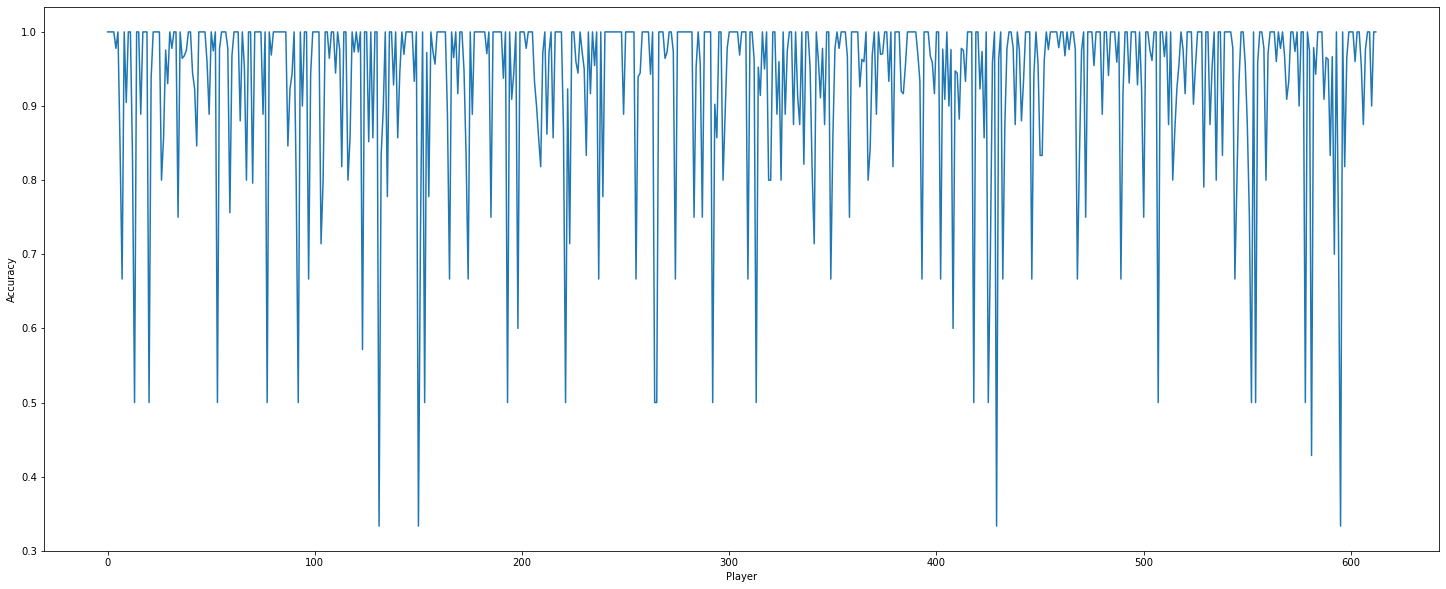

In [38]:



score_arr_SGD = []
f1_arr_SGD = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter] 
    
    # only if contains both classes, True and False
    if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:

        score,f1= model_eval(df_batter,mod=SGDClassifier(random_state=0,max_iter=1000))
        score_arr_SGD.append(score)
        f1_arr_SGD.append(f1)
        
plt.plot(score_arr_SGD)
plt.xlabel('Player')
plt.ylabel('Accuracy')
print('Mean accuracy: '+str(np.mean(score_arr_SGD)))
print('Mean f1: '+str(np.mean(f1_arr_SGD)))

And finally RidgeClassifier:

Mean accuracy: 0.9372802611164159
Mean f1: 0.9103074557621506


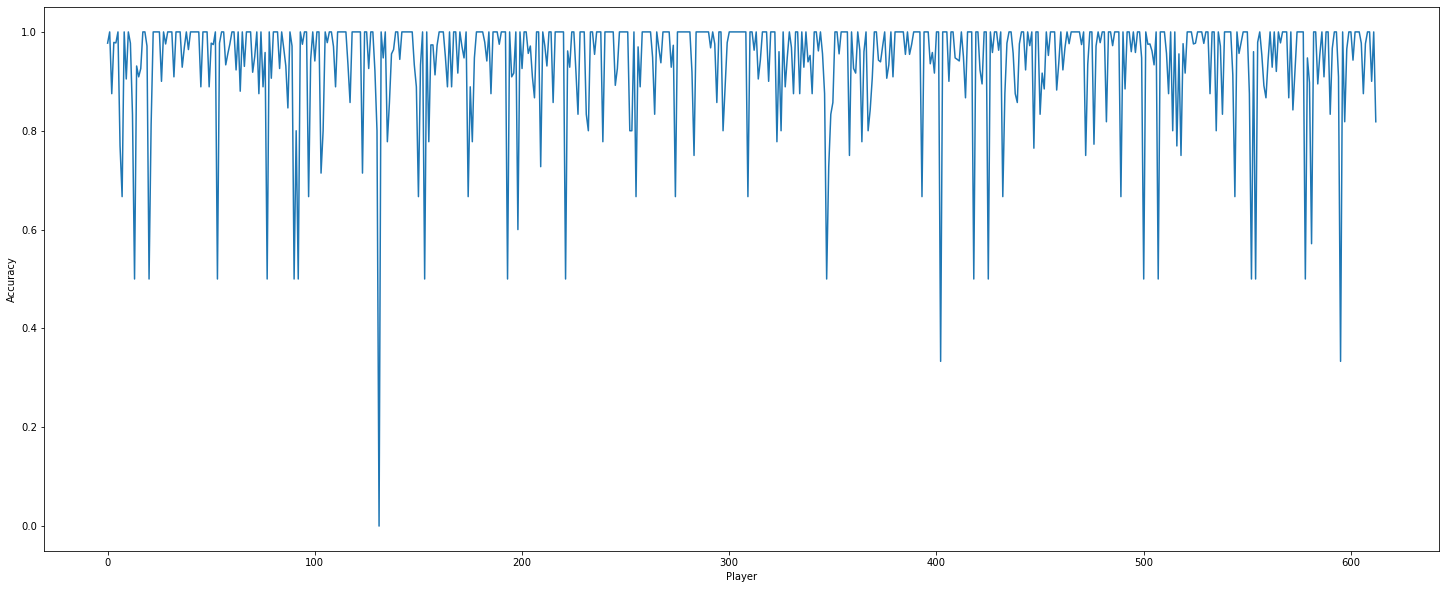

In [39]:

score_arr_R = []
f1_arr_R = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter] #put in order of date?
    
    # only if contains both classes, True and False
    if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
    
        score,f1= model_eval(df_batter,mod=RidgeClassifier(random_state=0))
        score_arr_R.append(score)
        f1_arr_R.append(f1)

plt.plot(score_arr_R)
plt.xlabel('Player')
plt.ylabel('Accuracy')
print('Mean accuracy: '+str(np.mean(score_arr_R)))
print('Mean f1: '+str(np.mean(f1_arr_R)))

Each model was an improvement over the last. Now, let's see if adding the knowledge of whether the player is currently on a 3-game streak makes any difference.

In [40]:
# LogisticRegression

pd.options.mode.chained_assignment = None

score_arr_LR_new = []
f1_arr_LR_new = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter]
    
    if len(df_batter) < 3:  # Too early for a streak
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter)
            score_arr_LR_new.append(score)
            f1_arr_LR_new.append(f1)
    else:
        
        # Make three new columns (to be deleted); one for whether each of prev three games had a hit
        df_batter['one_before_hit'] = [np.nan]+list(df_batter['any_hits'])[:-1]
        df_batter['two_before_hit'] = [np.nan]+[np.nan]+list(df_batter['any_hits'])[:-2]
        df_batter['three_before_hit'] = [np.nan]+[np.nan]+[np.nan]+list(df_batter['any_hits'])[:-3]

        # The new column: Is player currently on a three game streak?
        df_batter['prev_three_hits'] = np.where(df_batter['one_before_hit'] & df_batter['two_before_hit'] & df_batter['three_before_hit'],True,False)

        # Can drop these now
        df_batter = df_batter.drop(['one_before_hit', 'two_before_hit','three_before_hit'], axis=1)

    
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter)
            score_arr_LR_new.append(score)
            f1_arr_LR_new.append(f1)
            
print('Avg accuracy: '+str(np.mean(score_arr_LR_new)))
print('Avg f1: '+str(np.mean(f1_arr_LR_new)))

Avg accuracy: 0.9086217586295994
Avg f1: 0.8611625123900375


In [41]:
print('Avg accuracy: '+str(np.mean(score_arr_LR_new)))
print('Avg f1: '+str(np.mean(f1_arr_LR_new)))

Avg accuracy: 0.9086217586295994
Avg f1: 0.8611625123900375


Text(0.5, 1.0, 'Log Reg: Difference between cases where we include or exclude knowledge of 3-game streaks')

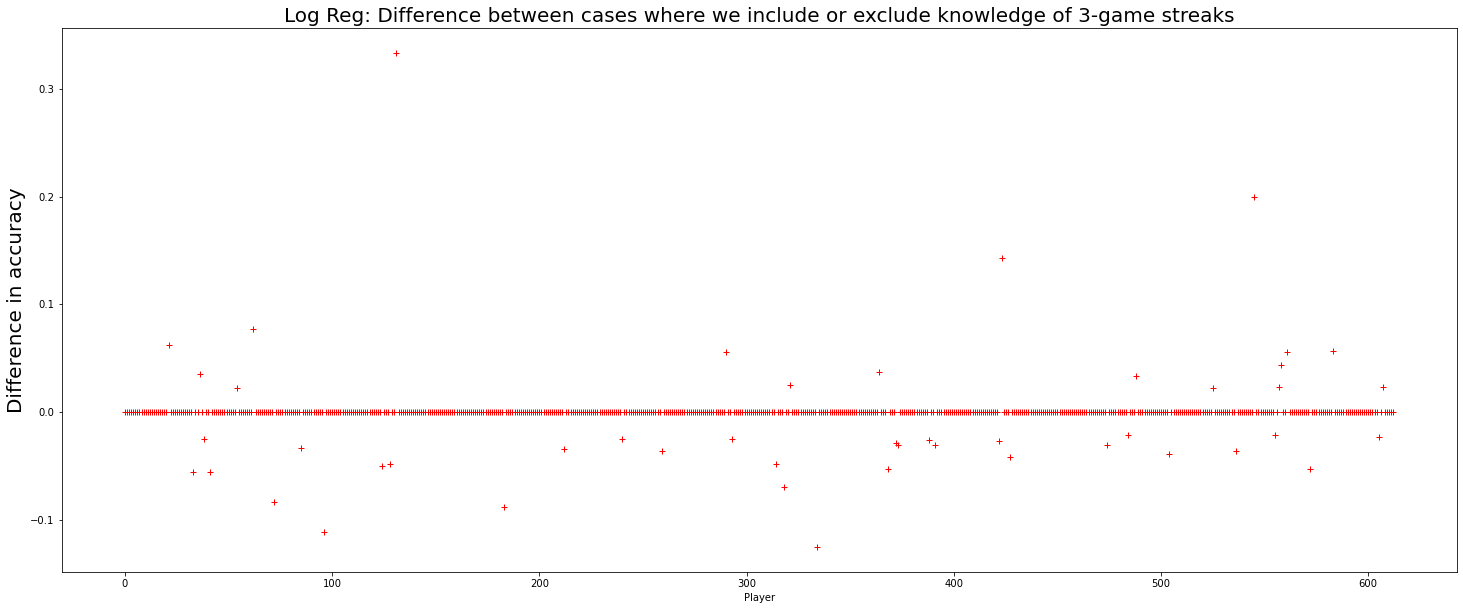

In [42]:
plt.plot(np.array(score_arr_LR_new)-np.array(score_arr_LR),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in accuracy',fontsize=20)
plt.title('Log Reg: Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

Text(0.5, 1.0, 'Log Reg: Difference between cases where we include or exclude knowledge of 3-game streaks')

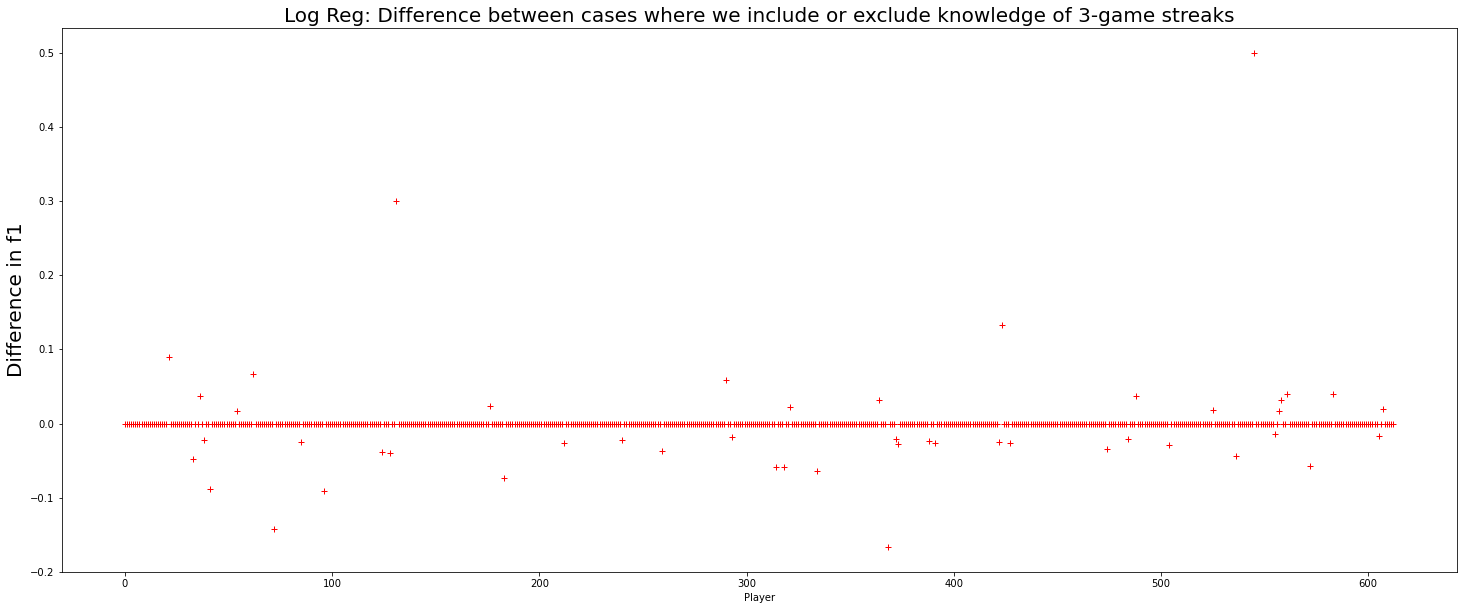

In [43]:
plt.plot(np.array(f1_arr_LR_new)-np.array(f1_arr_LR),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in f1',fontsize=20)
plt.title('Log Reg: Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

In [44]:
# Now with SGD

score_arr_SGD_new = []
f1_arr_SGD_new = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter]
    
    if len(df_batter) < 3: 
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter,mod=SGDClassifier(random_state=0,max_iter=1000))
            score_arr_SGD_new.append(score)
            f1_arr_SGD_new.append(f1)
    else:
        df_batter['one_before_hit'] = [np.nan]+list(df_batter['any_hits'])[:-1]
        df_batter['two_before_hit'] = [np.nan]+[np.nan]+list(df_batter['any_hits'])[:-2]
        df_batter['three_before_hit'] = [np.nan]+[np.nan]+[np.nan]+list(df_batter['any_hits'])[:-3]

        df_batter['prev_three_hits'] = np.where(df_batter['one_before_hit'] & df_batter['two_before_hit'] & df_batter['three_before_hit'],True,False)

        df_batter = df_batter.drop(['one_before_hit', 'two_before_hit','three_before_hit'], axis=1)

    
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter,mod=SGDClassifier(random_state=0,max_iter=1000))
            score_arr_SGD_new.append(score)
            f1_arr_SGD_new.append(f1)

In [45]:
print('Avg accuracy: '+str(np.mean(score_arr_SGD_new)))
print('Avg f1: '+str(np.mean(f1_arr_SGD_new)))

Avg accuracy: 0.9296450095452709
Avg f1: 0.9034620330725324


Text(0.5, 1.0, 'Difference between cases where we include or exclude knowledge of 3-game streaks')

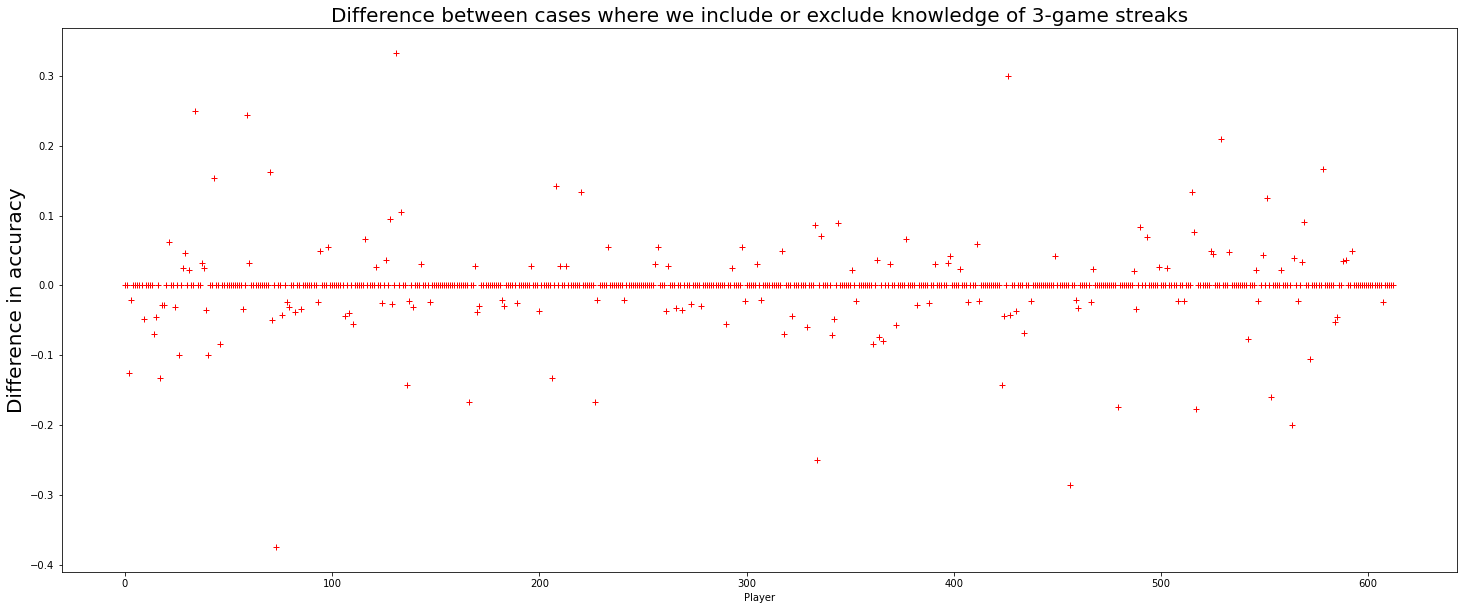

In [46]:
plt.plot(np.array(score_arr_SGD_new)-np.array(score_arr_SGD),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in accuracy',fontsize=20)
plt.title('Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

Text(0.5, 1.0, 'Difference between cases where we include or exclude knowledge of 3-game streaks')

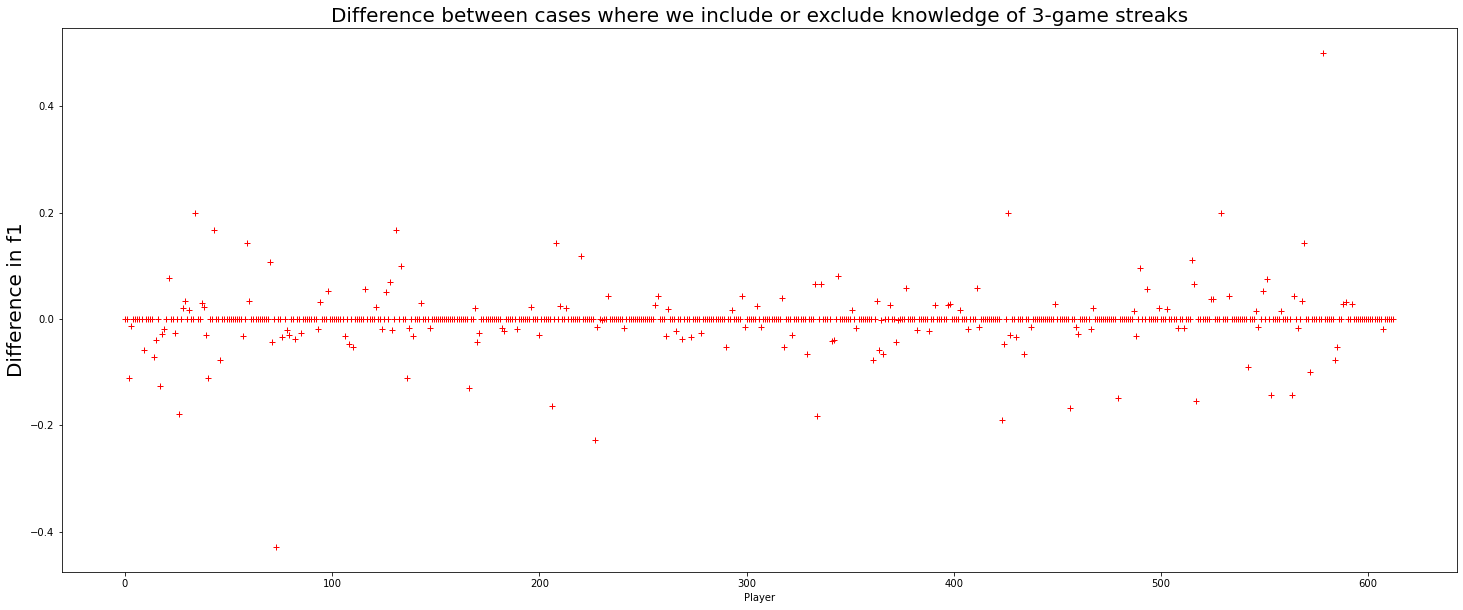

In [47]:
plt.plot(np.array(f1_arr_SGD_new)-np.array(f1_arr_SGD),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in f1',fontsize=20)
plt.title('Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

In [48]:
# And finally Ridge

score_arr_R_new = []
f1_arr_R_new = []

for batter in batters:
    
    df_batter = df[df['batter'] == batter]
    
    if len(df_batter) < 3: 
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter,mod=RidgeClassifier(random_state=0))
            score_arr_R_new.append(score)
            f1_arr_R_new.append(f1)
    else:
        df_batter['one_before_hit'] = [np.nan]+list(df_batter['any_hits'])[:-1]
        df_batter['two_before_hit'] = [np.nan]+[np.nan]+list(df_batter['any_hits'])[:-2]
        df_batter['three_before_hit'] = [np.nan]+[np.nan]+[np.nan]+list(df_batter['any_hits'])[:-3]

        df_batter['prev_three_hits'] = np.where(df_batter['one_before_hit'] & df_batter['two_before_hit'] & df_batter['three_before_hit'],True,False)

        df_batter = df_batter.drop(['one_before_hit', 'two_before_hit','three_before_hit'], axis=1)

    
        if len(df_batter[df_batter['any_hits']==False])>1 and len(df_batter[df_batter['any_hits']==True])>1:
            score,f1= model_eval(df_batter,mod=RidgeClassifier(random_state=0))
            score_arr_R_new.append(score)
            f1_arr_R_new.append(f1)



In [49]:
print('Avg accuracy: '+str(np.mean(score_arr_R_new)))
print('Avg f1: '+str(np.mean(f1_arr_R_new)))

Avg accuracy: 0.9335396453641177
Avg f1: 0.9082560873466433


Text(0.5, 1.0, 'Difference between cases where we include or exclude knowledge of 3-game streaks')

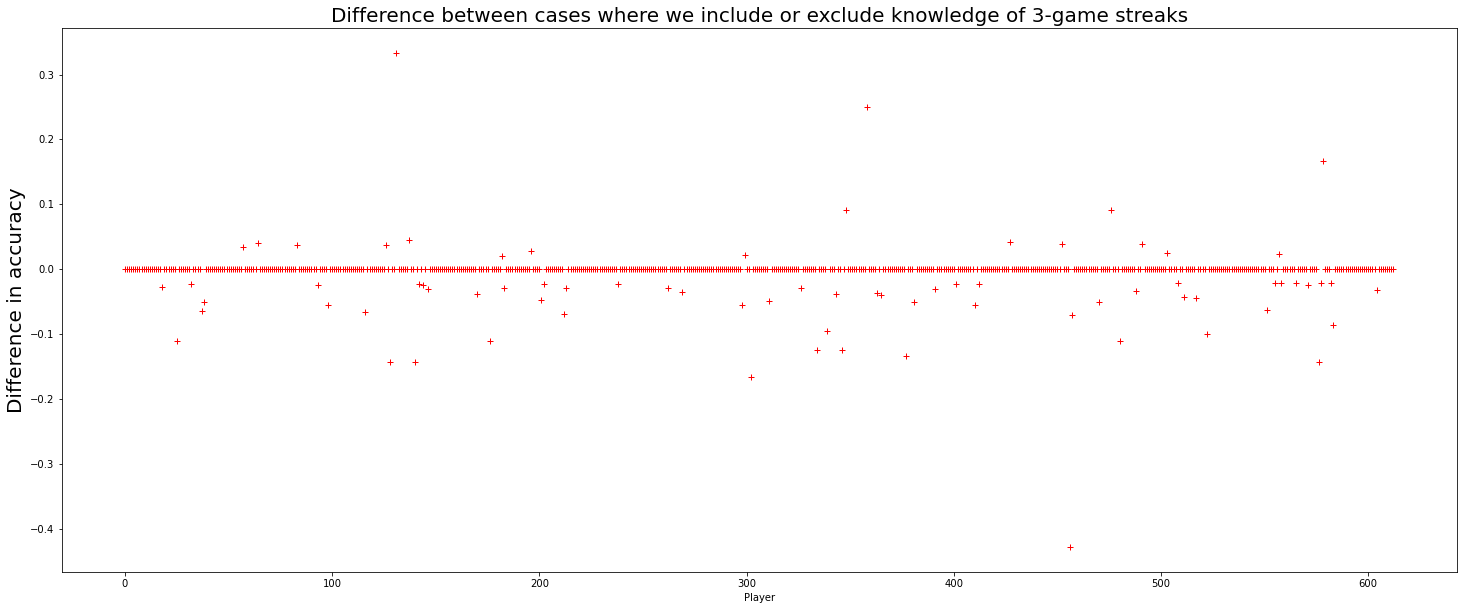

In [50]:
plt.plot(np.array(score_arr_R_new)-np.array(score_arr_R),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in accuracy',fontsize=20)
plt.title('Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

Text(0.5, 1.0, 'Difference between cases where we include or exclude knowledge of 3-game streaks')

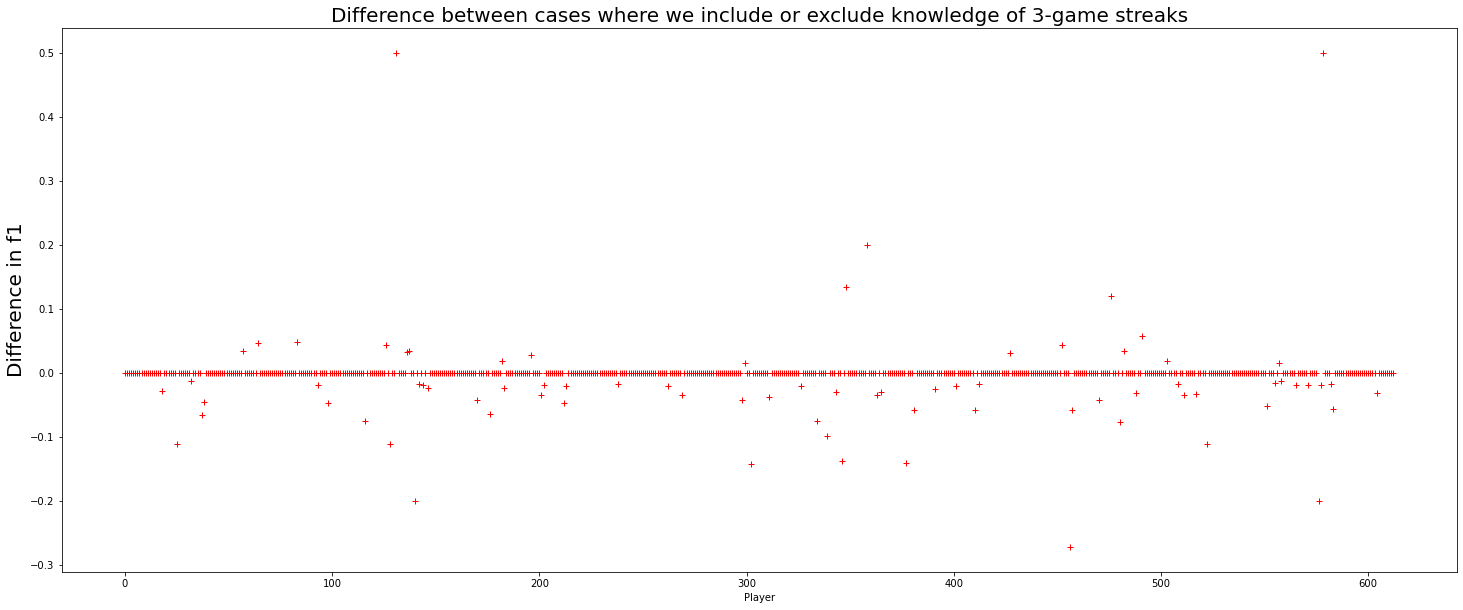

In [51]:
plt.plot(np.array(f1_arr_R_new)-np.array(f1_arr_R),'r+')
plt.xlabel('Player')
plt.ylabel('Difference in f1',fontsize=20)
plt.title('Difference between cases where we include or exclude knowledge of 3-game streaks',fontsize=20)

In [52]:
# I tried statsmodels.formula.api.glm and statsmodels.api.Probit and got 
#PerfectSeparationError: Perfect separation detected, results not available

To summarize, when comparing the original case, to the case where we consider a 3-game streak:

Logistic Regression: Mean accuracy slightly decreases 0.9088 -> 0.9086. Mean f1-score slightly increases 0.8610 -> 0.8612
    
SGD: Mean accuracy slightly decreases 0.9308 -> 0.9296. Mean f1-score slightly decreases 0.9048 -> 0.9035

Ridge: Mean accuracy slightly decreases 0.9373 -> 0.9335. Mean f1-score slightly decreases 0.9103 -> 0.9083
    
    
**Overall, I don't see an added value in considering a 3-game streak for the prediction of hits. Based on this dataset, it looks to me like hot-hand is not a real performance phenomenon.**


**Further ideas to continue this project**

- I could have done some hyperparameter tuning (eg the solver used by LogisticRegression), maybe with GridSearchCV. However, the accuracy scores are already pretty high.

- I'm suspicious of the perfect accuracy and f1 score in the case of Semien (who has the longest streak).

- Could have looked at the data as a time series and examined autocorrelation.

- Could be more quantitative to see if the streak helps, eg p-value with null hypothesis being that hot-hand is not a real phenomenon?

- In Q3, why the outliers? Those players may have played very few games.

- Q5: another possible grouping could be how many singles vs doubles vs triples vs home runs the player got in each game. 

- Q5: quantify differences better, maybe a simple horizontal best fit line. Or p-value with again null hypothesis being no difference between groups?

- Q6: I could have written a helper function to make this easier to read. 

- Q6: I could better quantify the differences in scores when using the 3-game streak.